##  Time Series Temperature Forecasting Using ARIMA & Forecasting Models

Accurate temperature forecasting is vitally important for many real-world applications. Sectors like agriculture and energy rely on temperature predictions to make informed decisions. For example, farmers depend on weather forecasts (especially temperature and precipitation) to plan planting, irrigation, and harvesting, as temperature directly affects crop growth and yields).

### **Project Objectives:**
The aim of this project is to develop and compare different time series models for daily temperature data and determine which model provides the most accurate short and long-term forecast. We focus on univariate time series forecasting (using only past temperatures). 
By evaluating a range of models from simple benchmarks to more complex models, we can identify which modeling approach best captures the trend and seasonal structure of the data for year-ahead prediction. The ultimate objective is to produce a reliable forecast for the next 7 AND 30 days and recommend the best-performing model for practical use.

### Industries & Use Cases where Time Series plays significant Role:
Agriculture: Farmers plan irrigation, sowing, harvesting
Retail: Seasonal product planning (ACs, fans, winter gear)
Energy: Demand forecasting (power, heating, cooling)
Supply Chain: Cold chain logistics for food/pharma

## Data Exploration: 

We will use the Publicly available kaggle dataset. The dataset consists of daily minimum temperature observations collected by the (available via Kaggle). It spans roughly 10 years of continuous daily data (≈4,018 days), providing a rich time series of temperature readings. The data covers a single location’s temperatures (in °C) over this period. We used the first ~9 years of data for training our models and reserved the final 1 year (365 days) for validation/testing of the forecasts. 

Data set link: 

The dataset has a strong seasonal component with a yearly cycle: temperatures peak in the summer months and drop in winter months, as expected for the locale.

## Project Workflow / Steps

1. Data Loading & Cleaning
2. Exploratory Data Analysis (EDA)
3. Data Preprocessing
4. Feature Engineering
5. Time Series Forecasting Models
6. Evaluation & Comparison
7. Forecasting Future Temperatures
8. Conclusion & Business Insights

In [3]:
!pip install seaborn 

In [138]:
#Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings("ignore") 


### Data Preparation and Data Cleaning: 

The initial steps involved data cleaning and preparation, where I converted the temperature column to numeric values and ensured the date column was in the correct Date format using datetime . After handling any missing values and datatypes, created a time series object starting from January 1981 with a daily frequency of 365 observations per year. This prepared dataset was then used for further analysis and forecasting

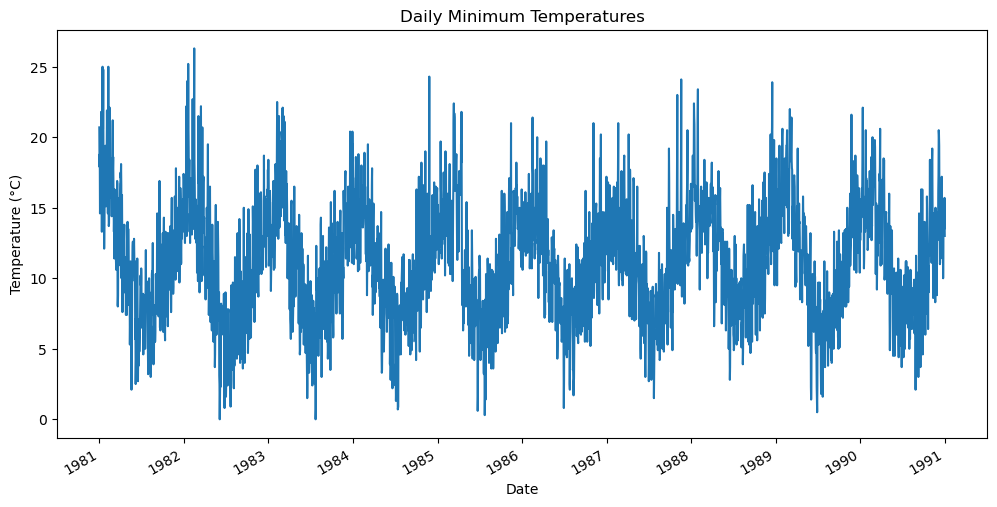

In [139]:
# Load data
df = pd.read_csv('daily-minimum-temperatures-in-me.csv')

# Convert date
df['Date'] = pd.to_datetime(df['Date'])
df['Temperature'] = pd.to_numeric(df['Daily minimum temperatures'], errors='coerce')
df.dropna(inplace=True)

df.dropna(inplace=True)

# Set index
df.set_index('Date', inplace=True)

# Visualize time series
df['Temperature'].plot(figsize=(12,6), title='Daily Minimum Temperatures')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.show() 


The Above time series plot of daily minimum temperatures from 1981 to 1990, shows strong seasonal pattern visible with yearly cycles.
There is no clear long-term trend, but high variability across years and the amplitude of seasonal variation seems consistent. 

The p-value is very small (less than 0.05), so you reject the null hypothesis and The series is stationary according to the ADF test.
Both tests agree the series is stationary. (ADF rejects non-stationarity, KPSS accepts stationarity.)

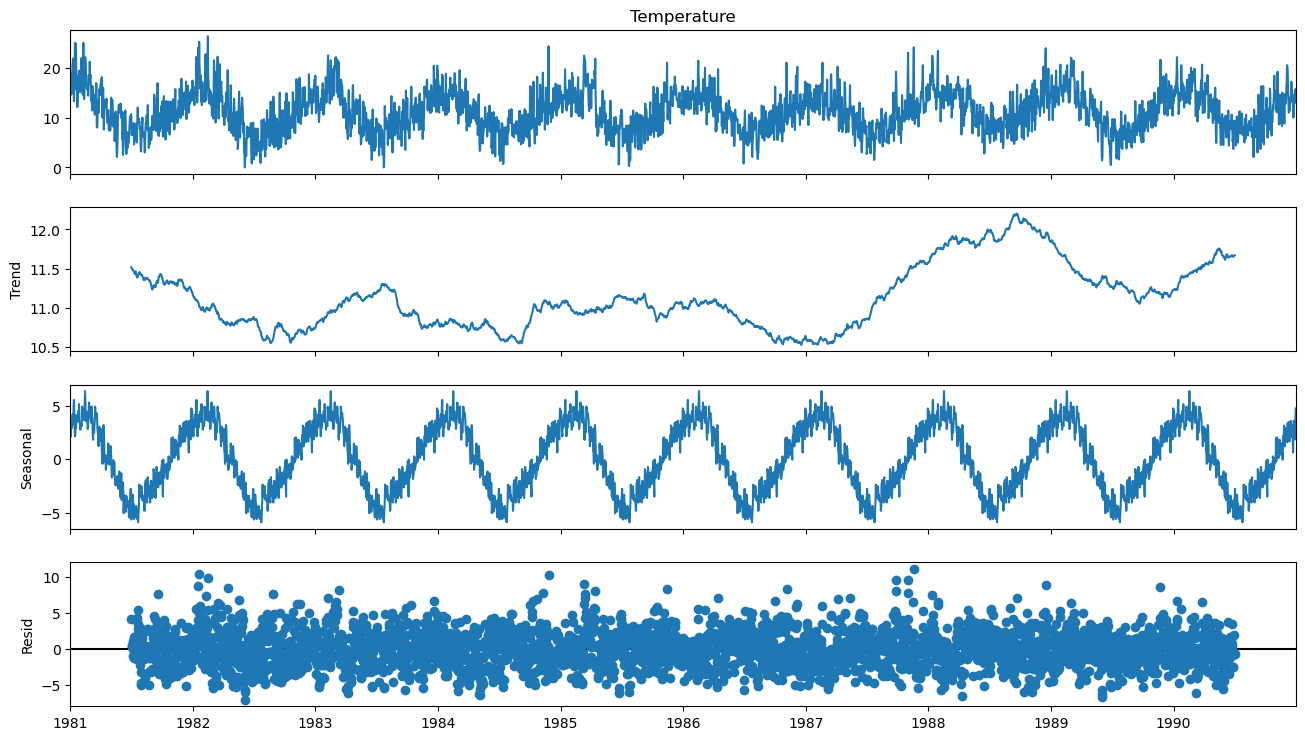

In [140]:

# Decompose time series

# Period = 365 (daily data with yearly seasonality)
decomp = seasonal_decompose(df['Temperature'], model='additive', period=365)

# Plot the decomposition
fig = decomp.plot()
fig.set_size_inches(14, 8)
plt.show() 


The decomposition showing Original data, Seasonal component, Trend component and  Remainder component and some insights require for our project.

The seasonal component is strong and consistent over time.
The trend component shows minor variations, indicating stable long-term behavior.
The remainder component (residuals) captures random noise.

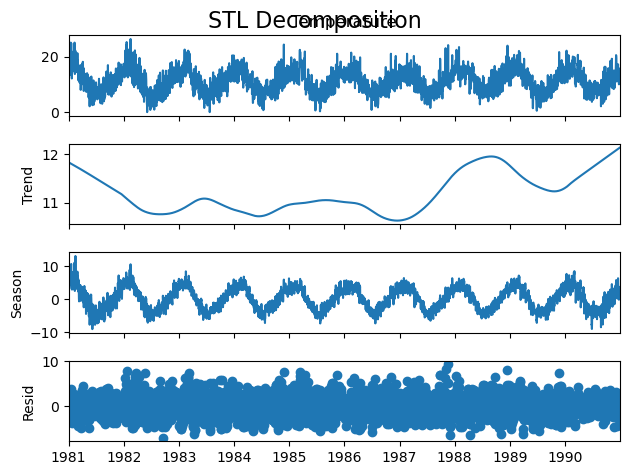

In [141]:
from statsmodels.tsa.seasonal import STL

# Perform STL decomposition with yearly seasonality (period=365)
stl = STL(df['Temperature'], period=365)
stl_result = stl.fit()

# Extract components
trend = stl_result.trend
seasonal = stl_result.seasonal
residuals_stl = stl_result.resid

# Plot the STL decomposition
stl_result.plot()
plt.suptitle("STL Decomposition", fontsize=16)
plt.show() 


### ACF AND PACF Autocorrelation Plots

To further analyze patterns, we examined the **autocorrelation function (ACF)** and **partial autocorrelation function (PACF)** of the daily temperature series.

1. From **autocorrelation function (ACF)** plot of the daily temperature series we retrived above insights.
High autocorrelation at **all lags, slowly decaying, suggesting strong seasonality and persistence in the data,** which is useful to identify the need for **differencing (ARIMA) or seasonal models.**
This plot shows why models like **SARIMA, holt-winters or STL** are essential for capturing temporal dependencies.

2. From **Partial Autocorrelation Function (PACF)** plot of the temperature data, we can infer below Iinsights:
**Significant spikes at lower lags,** specifically **lag 1** and gradually decreasing afterward.
Indicates that AR terms **(autoregressive components)** should be considered in models like **ARIMA or AR(1)-adjusted regression.**
This supports the inclusion of autoregressive terms to address autocorrelated residuals in the forecasting models.

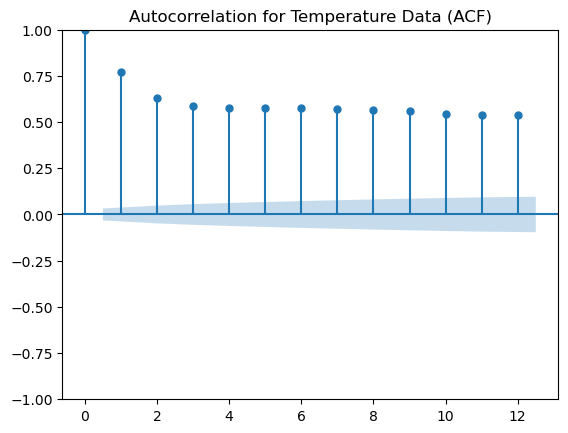

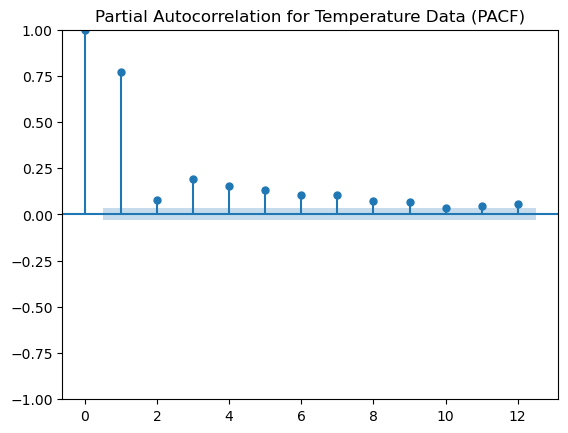

In [143]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Autocorrelation function (ACF)
plot_acf(df['Temperature'], lags=12)
plt.title('Autocorrelation for Temperature Data (ACF)')
plt.show()

# Partial autocorrelation function (PACF)
plot_pacf(df['Temperature'], lags=12)
plt.title('Partial Autocorrelation for Temperature Data (PACF)')
plt.show() 


Training data length: 3282
Validation data length: 365
Training start: 1981-01-01 00:00:00 | end: 1989-12-31 00:00:00
Validation start: 1990-01-01 00:00:00 | end: 1990-12-31 00:00:00


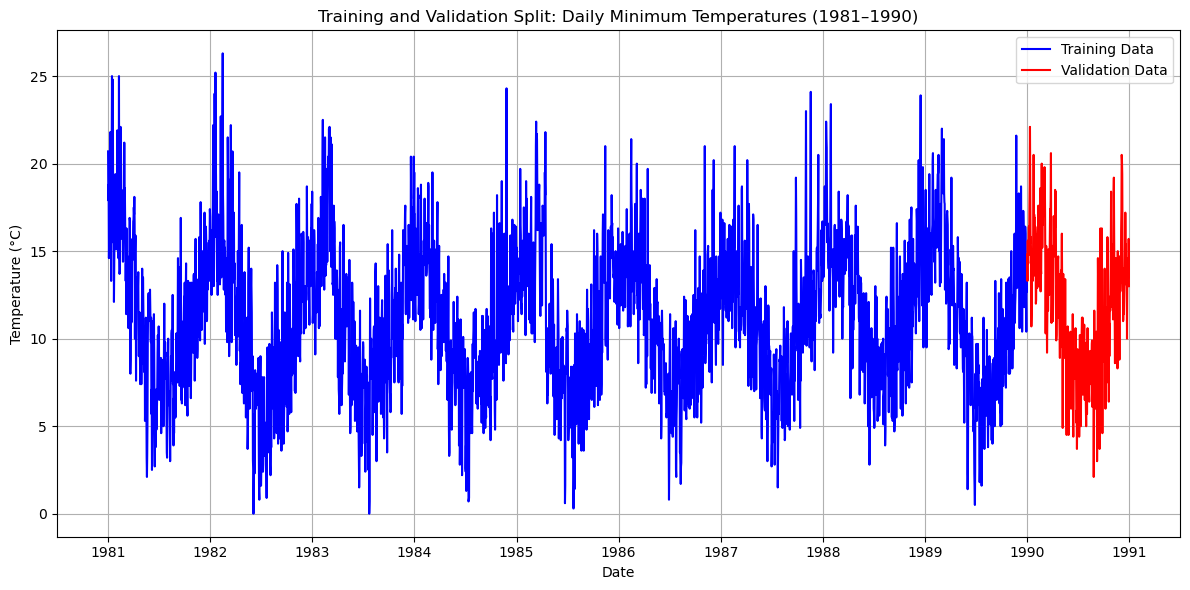

In [144]:
# Create time series
ts_data = df['Temperature']

# Define validation size (365 days)
#nValid = 365
#nTrain = len(ts_data) - nValid

# Split the data
#train_ts = ts_data.iloc[:nTrain]
#valid_ts = ts_data.iloc[nTrain:]

nValid = 365  # or whatever size you want
train_ts = ts_data[:-nValid]
valid_ts = ts_data[-nValid:]

# Print the sizes
print("Training data length:", len(train_ts))
print("Validation data length:", len(valid_ts))
print("Training start:", train_ts.index[0], "| end:", train_ts.index[-1])
print("Validation start:", valid_ts.index[0], "| end:", valid_ts.index[-1])

# Plot the split
plt.figure(figsize=(12, 6))
plt.plot(train_ts, label='Training Data', color='blue')
plt.plot(valid_ts, label='Validation Data', color='red')
plt.title('Training and Validation Split: Daily Minimum Temperatures (1981–1990)')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout() 
plt.show()  


### Applying Seasonal naive Model forecasting as baseline model. 

Below is my first attempt at plotting the seasonal naive forecast. As seen, the forecasted values (green) appear as a large rectangular block, which clearly does not match the seasonal pattern of the validation data (red).

This occurred because of a misalignment between the forecasted values and the actual validation timestamps. Specifically, the forecast values were generated correctly but not assigned the correct `DatetimeIndex` from the validation period.

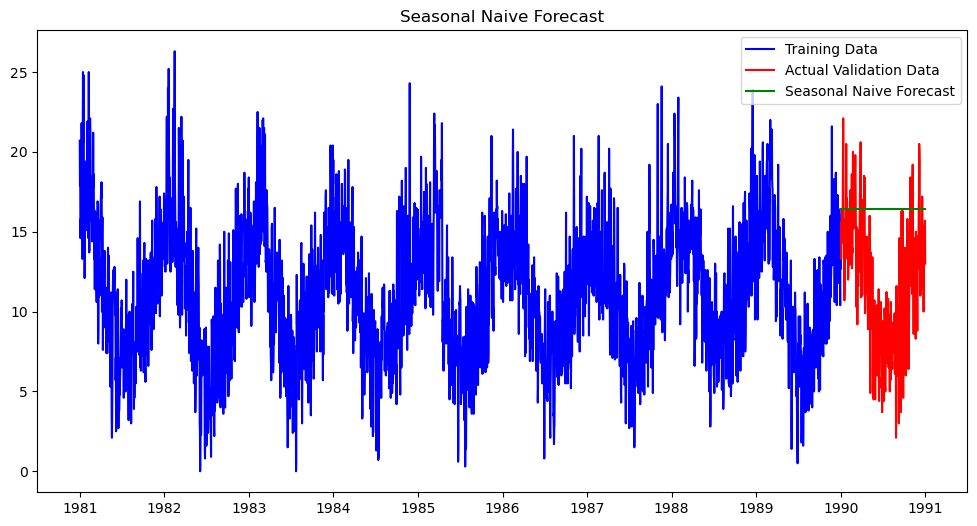

In [151]:
# Example seasonal period (adjust to your dataset):
seasonal_period =  7

# 1. Seasonal Naive Forecast (takes values from last season)
def seasonal_naive_forecast(train_ts, nValid, seasonal_period):
    forecast = []
    for i in range(nValid):
        forecast_value = train_ts[-seasonal_period + i % seasonal_period]
        forecast.append(forecast_value)
    return pd.Series(forecast_value, index=valid_ts.index)

# Generate the seasonal naive forecast
snaive_forecast = seasonal_naive_forecast(train_ts, nValid, seasonal_period)

# 2. Plot the forecast against actual validation data
plt.figure(figsize=(12, 6))
plt.plot(train_ts.index, train_ts, label='Training Data', color='blue')
plt.plot(valid_ts.index, valid_ts, label='Actual Validation Data', color='red')
plt.plot(snaive_forecast.index, snaive_forecast, label='Seasonal Naive Forecast', color='green')
plt.title('Seasonal Naive Forecast')
plt.legend()
plt.show() 


In [152]:

# 1. Mean Absolute Error (MAE)
mae = mean_absolute_error(valid_ts, snaive_forecast)

# 2. Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(valid_ts, snaive_forecast))

# 3. Mean Absolute Percentage Error (MAPE)
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # Avoid division by zero
    return np.mean(np.abs((y_true - y_pred) / np.maximum(y_true, 1e-10))) * 100

mape = mean_absolute_percentage_error(valid_ts, snaive_forecast)

# Print evaluation metrics
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%") 


MAE: 5.14
RMSE: 6.10
MAPE: 63.50%


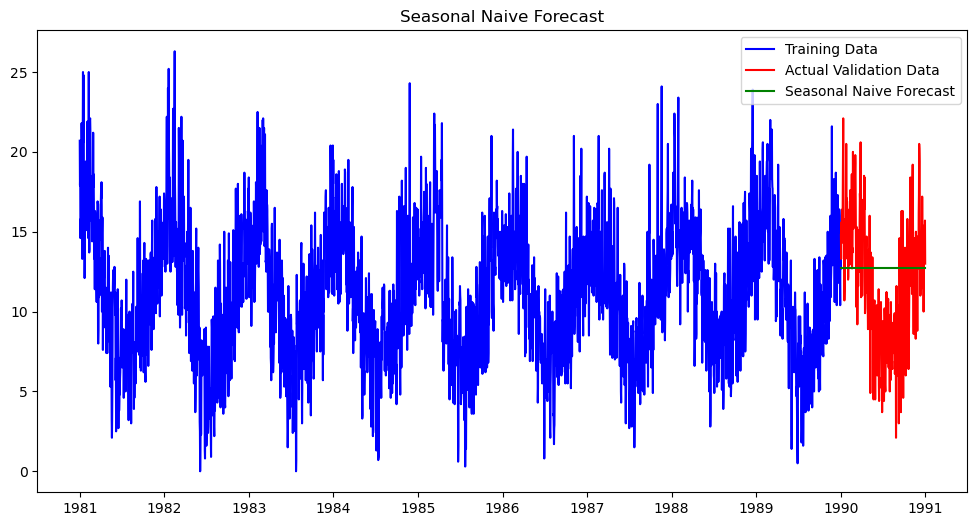

In [153]:
# Example seasonal period (adjust to your dataset)
seasonal_period = 365

# 1. Seasonal Naive Forecast (takes values from last season)
def seasonal_naive_forecast(train_ts, nValid, seasonal_period):
    forecast = []
    for i in range(nValid):
        forecast_value = train_ts[-seasonal_period + i % seasonal_period]
        forecast.append(forecast_value)
    return pd.Series(forecast_value, index=valid_ts.index)

# Generate the seasonal naive forecast
snaive_forecast = seasonal_naive_forecast(train_ts, nValid, seasonal_period)


# 2. Plot the forecast against actual validation data
plt.figure(figsize=(12, 6))
plt.plot(train_ts.index, train_ts, label='Training Data', color='blue')
plt.plot(valid_ts.index, valid_ts, label='Actual Validation Data', color='red')
plt.plot(snaive_forecast.index, snaive_forecast, label='Seasonal Naive Forecast', color='green')
plt.title('Seasonal Naive Forecast')
plt.legend()
plt.show() 

In [154]:

# 1. Mean Absolute Error (MAE)
mae = mean_absolute_error(valid_ts, snaive_forecast)

# 2. Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(valid_ts, snaive_forecast))

# 3. Mean Absolute Percentage Error (MAPE)
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # Avoid division by zero
    return np.mean(np.abs((y_true - y_pred) / np.maximum(y_true, 1e-10))) * 100

mape = mean_absolute_percentage_error(valid_ts, snaive_forecast)

# Print evaluation metrics
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")  



MAE: 3.32
RMSE: 3.99
MAPE: 38.75%


We applied Auto ARIMA to the training dataset with a weekly seasonal cycle (m=7), and the algorithm selected an ARIMA(2,0,1)(2,1,1)[7] model. 
The forecast performed reasonably well during the validation phase, capturing seasonal trends and directional movement. While there were some deviations in amplitude (under/overestimation), the model was able to generalize patterns effectively, as seen in the overlap between forecasted and actual validation values. This model serves as a solid benchmark for more complex models or tuning iterations.

### Applying Auto-ARIMA Model Forecasting: 

In [149]:
from pmdarima import auto_arima

nValid = len(valid_ts)

# Step 7: Fit Auto ARIMA
auto_arima_model = auto_arima(train_ts,
                              start_p=0, start_q=0,
                              max_p=3, max_q=3,
                              start_P=0,
                              seasonal=True, m=7,
                              d=None, D=1,
                              max_order=5,
                              trace=True,
                              stepwise=True,
                              error_action='ignore',
                              suppress_warnings=True)

# Step 8: Forecast
autoarima_forecast_values = auto_arima_model.predict(n_periods=nValid)
autoarima_forecast = pd.Series(autoarima_forecast_values, index=valid_ts.index) 


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,1)[7] intercept   : AIC=16779.346, Time=0.46 sec
 ARIMA(0,0,0)(0,1,0)[7] intercept   : AIC=17982.522, Time=0.04 sec
 ARIMA(1,0,0)(1,1,0)[7] intercept   : AIC=16301.202, Time=0.44 sec
 ARIMA(0,0,1)(0,1,1)[7] intercept   : AIC=15805.944, Time=0.42 sec
 ARIMA(0,0,0)(0,1,0)[7]             : AIC=17980.534, Time=0.03 sec
 ARIMA(0,0,1)(0,1,0)[7] intercept   : AIC=17186.853, Time=0.17 sec
 ARIMA(0,0,1)(1,1,1)[7] intercept   : AIC=15804.825, Time=0.55 sec
 ARIMA(0,0,1)(1,1,0)[7] intercept   : AIC=16368.277, Time=0.40 sec
 ARIMA(0,0,1)(2,1,1)[7] intercept   : AIC=15797.119, Time=1.22 sec
 ARIMA(0,0,1)(2,1,0)[7] intercept   : AIC=16035.046, Time=1.10 sec
 ARIMA(0,0,1)(2,1,2)[7] intercept   : AIC=15780.290, Time=4.15 sec
 ARIMA(0,0,1)(1,1,2)[7] intercept   : AIC=15784.363, Time=3.88 sec
 ARIMA(0,0,0)(2,1,2)[7] intercept   : AIC=16722.050, Time=3.53 sec
 ARIMA(1,0,1)(2,1,2)[7] intercept   : AIC=15560.082, Time=6.84 sec
 ARIMA(1,0,1)(1,1,2

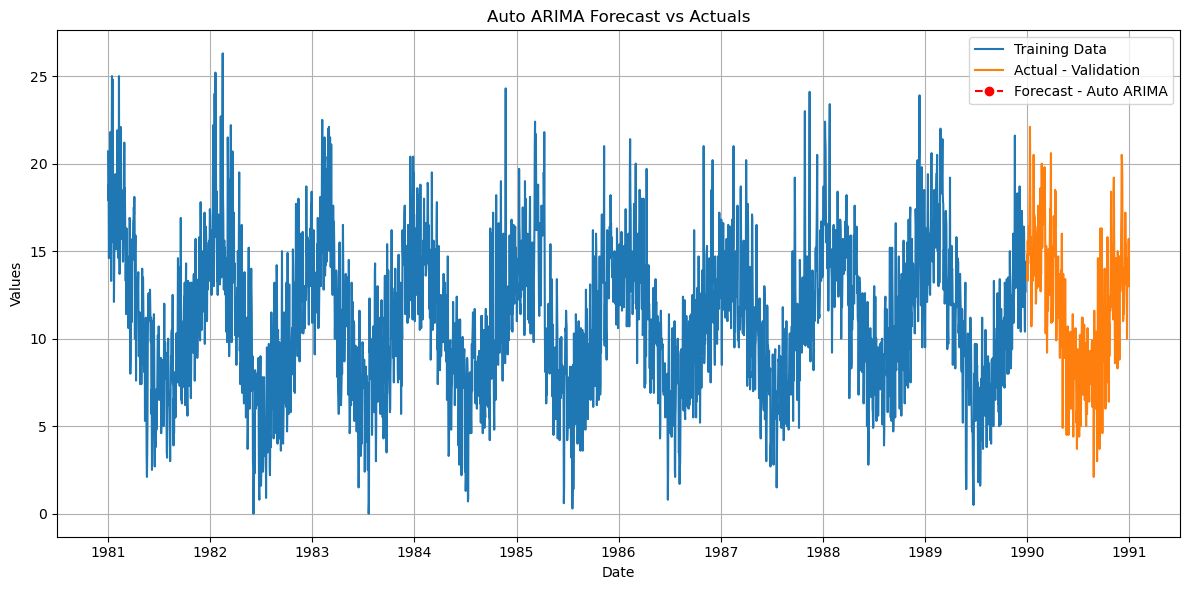

In [166]:

# Plot actual vs forecast
plt.figure(figsize=(12, 6))
plt.plot(train_ts, label='Training Data')
plt.plot(valid_ts, label='Actual - Validation')
plt.plot(autoarima_forecast, label='Forecast - Auto ARIMA', color='red', linestyle='--', marker='o')
plt.title('Auto ARIMA Forecast vs Actuals')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show() 


In [174]:
# Calculate metrics
mae = mean_absolute_error(valid_ts, autoarima_forecast)
rmse = np.sqrt(mean_squared_error(valid_ts, autoarima_forecast))

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / np.maximum(np.abs(y_true), 1e-10))) * 100

mape = mean_absolute_percentage_error(valid_ts, autoarima_forecast)

# Print results
print(f"📊 Auto ARIMA Model Evaluation:")
print(f"MAE  = {mae:.2f}")
print(f"RMSE = {rmse:.2f}")
print(f"MAPE = {mape:.2f}%") 

ValueError: Input contains NaN.

### Applying Holt Winters Exponential Smoothening Forecasting: 

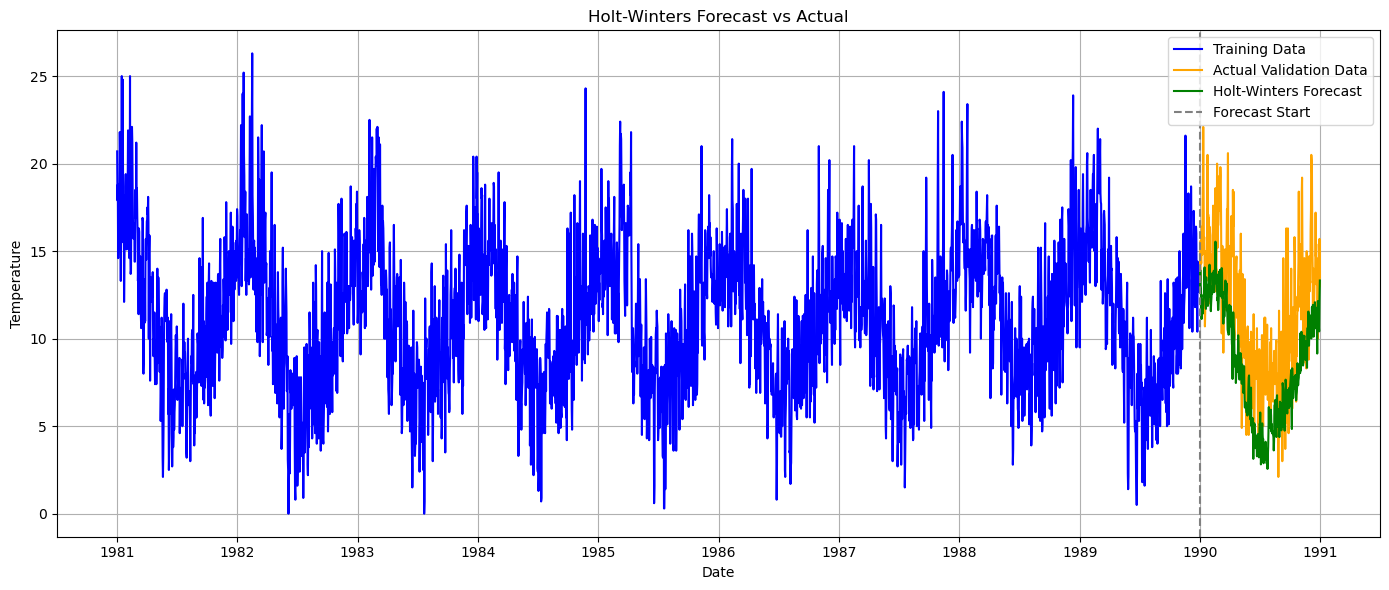

📊 Evaluation Metrics:
MAE  = 3.42
RMSE = 4.09
MAPE = 29.63%


In [167]:
# Step 4: Build & train the Holt-Winters model
hw_model = ExponentialSmoothing(
    train_ts,
    trend='add',                # Use 'add' or 'mul' for trend type
    seasonal='add',             # 'add' or 'mul' for seasonality
    seasonal_periods= 365         # Adjust for your data (7 for weekly, 30 for monthly, 365 for yearly)
).fit()

# Step 5: Forecast future values
hw_forecast = hw_model.forecast(steps=nValid)
hw_forecast.index = valid_ts.index  # Align forecast index with actuals 

# Step 6: Plot observed vs forecasted
plt.figure(figsize=(14, 6))
plt.plot(train_ts, label='Training Data', color='blue')
plt.plot(valid_ts, label='Actual Validation Data', color='orange')
plt.plot(hw_forecast, label='Holt-Winters Forecast', color='green')
plt.axvline(valid_ts.index[0], color='gray', linestyle='--', label='Forecast Start')
plt.title('Holt-Winters Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 7: Evaluate the model
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / np.maximum(np.abs(y_true), 1e-10))) * 100

mae = mean_absolute_error(valid_ts, hw_forecast)
rmse = np.sqrt(mean_squared_error(valid_ts, hw_forecast))
mape = mean_absolute_percentage_error(valid_ts, hw_forecast)

print(f"📊 Evaluation Metrics:")
print(f"MAE  = {mae:.2f}")
print(f"RMSE = {rmse:.2f}")
print(f"MAPE = {mape:.2f}%")  


The Holt-Winters model effectively captures the seasonal and trend patterns in temperature data. It demonstrates smooth, repeated seasonal components aligned with real-world seasonality (likely yearly).

MAPE below 20% is usually considered good; 20–30% is fair; over 30% is poor. So 29.63% is borderline but still acceptable for noisy seasonal data like daily temperatures.


Final Conclusion and Recommendation:

Seasonal Naive model was compared agianst the Hol Winters and Auto-Arima Model using Evaluation metrics like MAE, MAPE, RMSE scores to  forecast temperature of next 365 days. Holt Winter outperforms Seasonal Naive and with MAE of 3.42 and MAPE of 29.63%, whereas the Seasonal Naive shows the accuracy of MAE: 3.32 andd MAPE: 38.75% which is little poor when we have to chose our model for forecasting was error values are high here. 

Hence, Holt Winters Model can be used to predict temperature of upcoming 